<a href="https://colab.research.google.com/github/charucheema/Data-preprocessing--EDA/blob/main/CMPE255_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **New York City Airbnb Dataset**

Dataset is inspired from here: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [39]:
import pandas as pd
airbnb_df = pd.read_csv('/AB_NYC_2019.csv')

**Lets take a look at first few records to get an idea about the dataset we are working on**

In [40]:
print(airbnb_df.shape)
airbnb_df.head(10)

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


**A cursory glance at the dataset snippet above tells us that there are some null values which needs to be handled as part of data cleaning.**

In [41]:
airbnb_df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

**Host specific attributes like host_id, host_name, calculated_host_listings_count aren't going to contribute much to our analysis, so we should be good to drop these columns.**


Similarly listing 'id' is inconsequential to our analysis.

In [42]:
airbnb_df.drop(['host_name', 'id', 'host_id', 'calculated_host_listings_count'], axis=1, inplace=True)
airbnb_df.dtypes

name                    object
neighbourhood_group     object
neighbourhood           object
latitude               float64
longitude              float64
room_type               object
price                    int64
minimum_nights           int64
number_of_reviews        int64
last_review             object
reviews_per_month      float64
availability_365         int64
dtype: object

## **Data Preparation and Data Cleaning**

In [43]:
airbnb_df.duplicated().sum()
airbnb_df.drop_duplicates(inplace=True)

In [44]:
airbnb_df.isnull().sum()

name                      16
neighbourhood_group        0
neighbourhood              0
latitude                   0
longitude                  0
room_type                  0
price                      0
minimum_nights             0
number_of_reviews          0
last_review            10052
reviews_per_month      10052
availability_365           0
dtype: int64

In [45]:
airbnb_zero_reviews_df = airbnb_df.loc[(airbnb_df['number_of_reviews'] == 0)]
airbnb_zero_reviews_df.isnull().sum()

name                      10
neighbourhood_group        0
neighbourhood              0
latitude                   0
longitude                  0
room_type                  0
price                      0
minimum_nights             0
number_of_reviews          0
last_review            10052
reviews_per_month      10052
availability_365           0
dtype: int64

**We can see that last_review and reviews_per_month is null for listings with 0 number_of_reviews. Thus, reviews_per_month can be set to 0 for records with number_of_reviews = 0.**

In [46]:
airbnb_df.loc[(airbnb_df.reviews_per_month.isna()) & (airbnb_df.number_of_reviews == 0), 'reviews_per_month'] = 0
airbnb_df.isnull().sum()

name                      16
neighbourhood_group        0
neighbourhood              0
latitude                   0
longitude                  0
room_type                  0
price                      0
minimum_nights             0
number_of_reviews          0
last_review            10052
reviews_per_month          0
availability_365           0
dtype: int64

In [47]:
# Before fixing null values for 'last_review' column we need to take a closer look at its statistical importance, the last review date doesnt bring any statistical advantage.
# Also 'last_review' is null for almost 1/5 th of the dataset, imputing or interpolating it from existing records is going to introduce bias in dataset
# Therefore, best course of action to handle the null values for 'last_review' column is to drop the column.
airbnb_df.drop('last_review', axis=1, inplace=True)
print(airbnb_df.shape)
airbnb_df.dtypes

(48895, 11)


name                    object
neighbourhood_group     object
neighbourhood           object
latitude               float64
longitude              float64
room_type               object
price                    int64
minimum_nights           int64
number_of_reviews        int64
reviews_per_month      float64
availability_365         int64
dtype: object

In [48]:
# 'name' might have some information which can be correlated with price, for example "park facing".
#  Since 'name' is null for relatively smaller number of records (16), it'll be a good idea to remove the rows for which 'name' is null, rather than dropping the whole column.
airbnb_df.dropna(subset = ['name'], inplace=True)
print(airbnb_df.shape)


(48879, 11)


In [49]:
# We have handled all the null values in dataset at this point
airbnb_df.isnull().sum()

name                   0
neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
number_of_reviews      0
reviews_per_month      0
availability_365       0
dtype: int64

In [51]:
# Lets work on removing the outliers based on prices from dataset, as they can skew our analysis in later stages.
import matplotlib.pyplot as plt
import numpy as np
price_array = airbnb_df["price"].to_numpy()
price_array[:10]


array([149, 225, 150,  89,  80, 200,  60,  79,  79, 150])

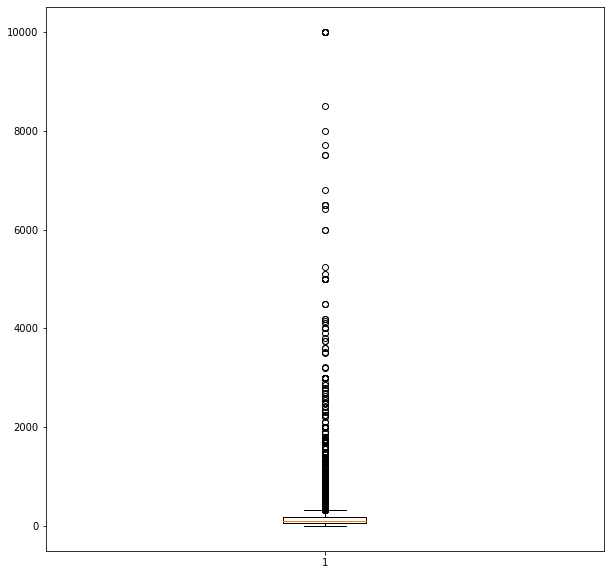

In [52]:
plt.boxplot(price_array)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()
# In the box plot we can see that we have quiet a bit of outliers lying outside q1 and q3 quartiles.

**Filter out the outliers based on following upper limit and lower limit**

In [53]:
# finding the upper limit
upper_limit = np.quantile(price_array, 0.97)
print(upper_limit)
# finding the lower limit
lower_limit = np.quantile(price_array, 0.03)
print(lower_limit)
print(airbnb_df.shape)
airbnb_df = airbnb_df[(airbnb_df['price'] < upper_limit) & (airbnb_df['price'] > lower_limit)]
print(airbnb_df.shape)

450.0
36.0
(48879, 11)
(45736, 11)


In [55]:
# As discussed easlier, the 'name' column might have certain key words which might be associated with high/low prices. For example "park facing", "prime location", "close to supermarket".
# Lets process this column to eliminate non textual element and just extract the words.
import re as re

def search_words(text):
  result = re.findall(r'\b[^\d\W]+\b', text)
  return " ".join(result)

airbnb_df['name'] = airbnb_df['name'].apply(lambda x : search_words(x))
airbnb_df['name'].head(20)

0                     Clean quiet apt home by the park
1                                Skylit Midtown Castle
2                       THE VILLAGE OF HARLEM NEW YORK
3                      Cozy Entire Floor of Brownstone
4      Entire Apt Spacious Studio Loft by central park
5              Large Cozy BR Apartment In Midtown East
6                                       BlissArtsSpace
7                      Large Furnished Room Near B way
8                     Cozy Clean Guest Room Family Apt
9                       Cute Cozy Lower East Side bdrm
10                        Beautiful on Upper West Side
11                     Central Manhattan near Broadway
12           Lovely Room Garden Best Area Legal rental
13    Wonderful Guest Bedroom in Manhattan for SINGLES
14                         West Village Nest Superhost
15                      Only stops to Manhattan studio
16                     Perfect for Your Parents Garden
17                                     Chelsea Perfect
18     Hip

## **Data Visualization**

**Lets take a look at correlation heatmap for cleaned dataset.**

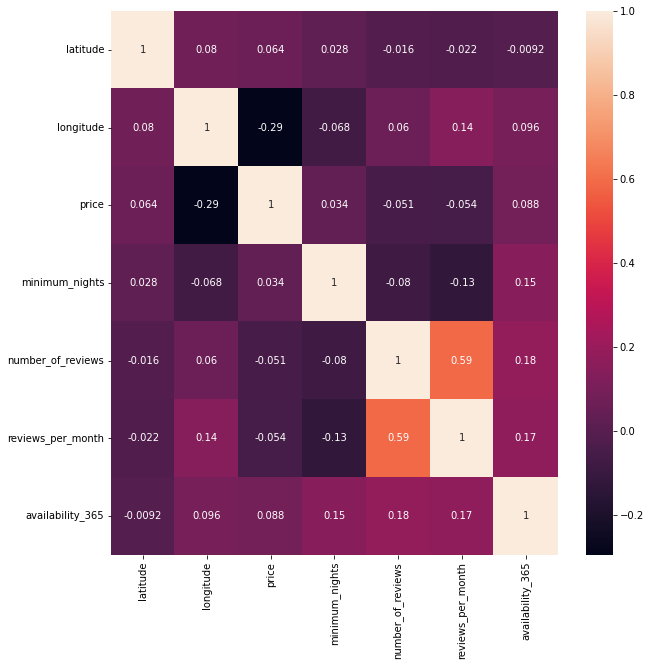

In [56]:
import seaborn as sb
correlation_matrix = airbnb_df.corr()
sb.heatmap(correlation_matrix, annot=True)

**Lets take a look at the Airbnb listing count neighbourhood_group wise. We can clearly see that Brooklyn and Manhattan dominates the listing count in New York.**

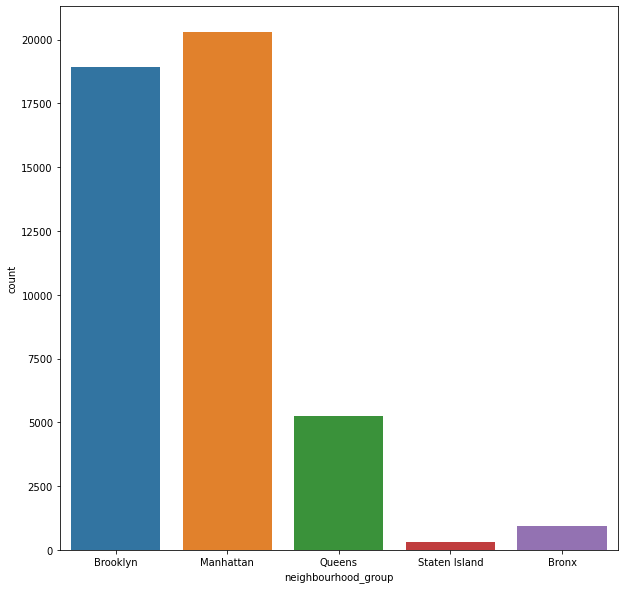

In [57]:
sb.countplot(x ='neighbourhood_group', data = airbnb_df)
plt.show()

Lets plot graph to see which neighbourhoods in each neighbourhood_group are hot spots for Airbnb listings

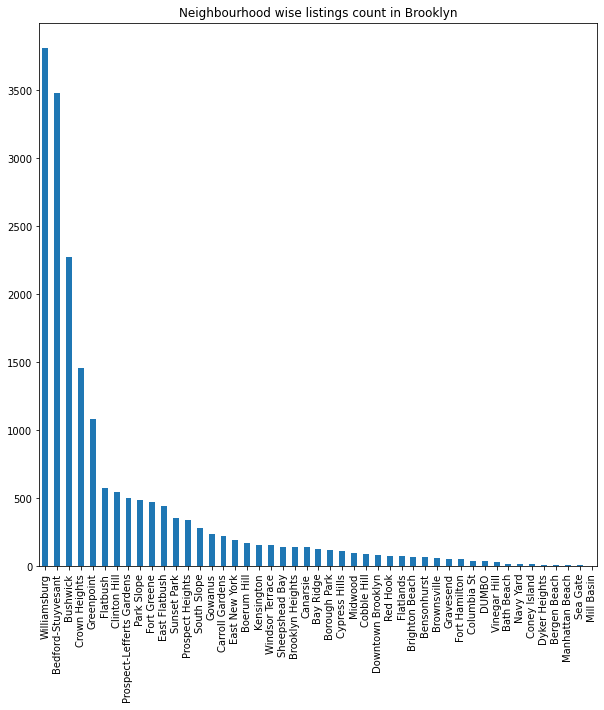

In [58]:
airbnb_brooklyn = airbnb_df[(airbnb_df['neighbourhood_group'] == 'Brooklyn')]
airbnb_brooklyn['neighbourhood'].value_counts().plot(kind="bar")
plt.title('Neighbourhood wise listings count in Brooklyn')
plt.show()


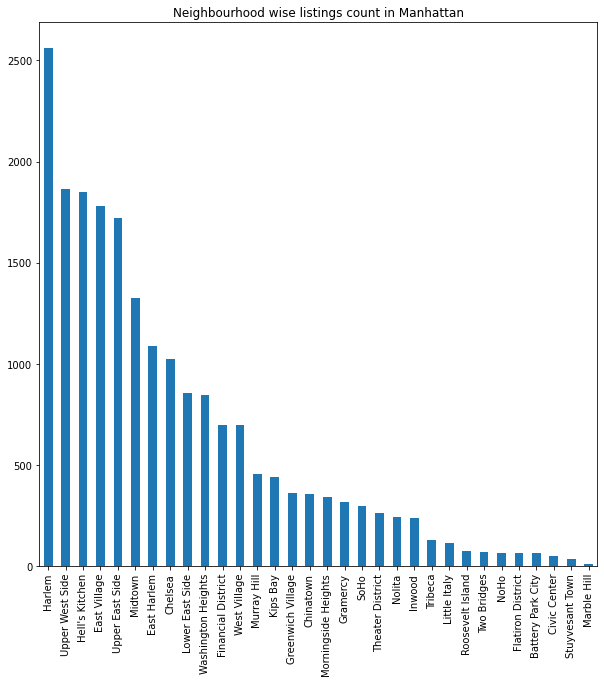

In [59]:
airbnb_manhattan = airbnb_df[(airbnb_df['neighbourhood_group'] == 'Manhattan')]
airbnb_manhattan['neighbourhood'].value_counts().plot(kind="bar")
plt.title('Neighbourhood wise listings count in Manhattan')
plt.show()

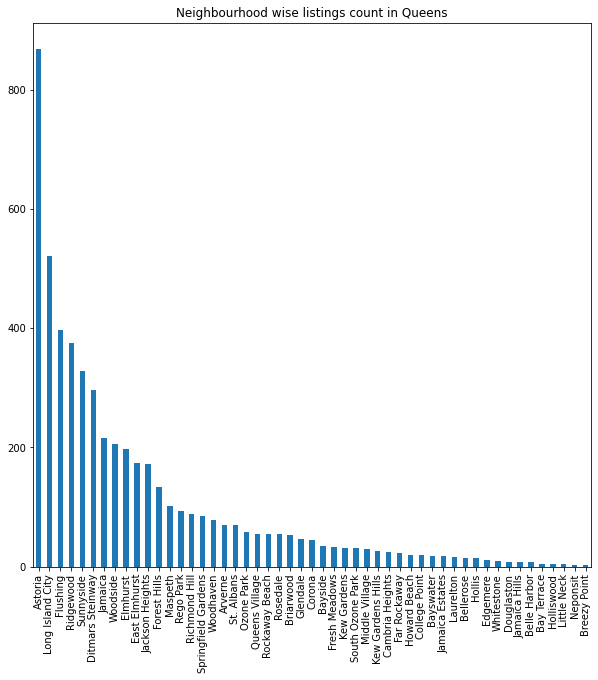

In [60]:
airbnb_queens = airbnb_df[(airbnb_df['neighbourhood_group'] == 'Queens')]
airbnb_queens['neighbourhood'].value_counts().plot(kind="bar")
plt.title('Neighbourhood wise listings count in Queens')
plt.show()

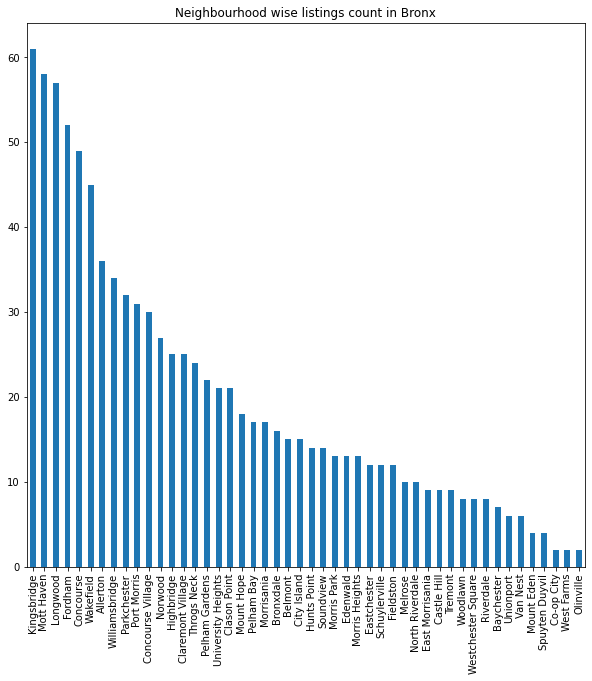

In [61]:
airbnb_bronx = airbnb_df[(airbnb_df['neighbourhood_group'] == 'Bronx')]
airbnb_bronx['neighbourhood'].value_counts().plot(kind="bar")
plt.title('Neighbourhood wise listings count in Bronx')
plt.show()

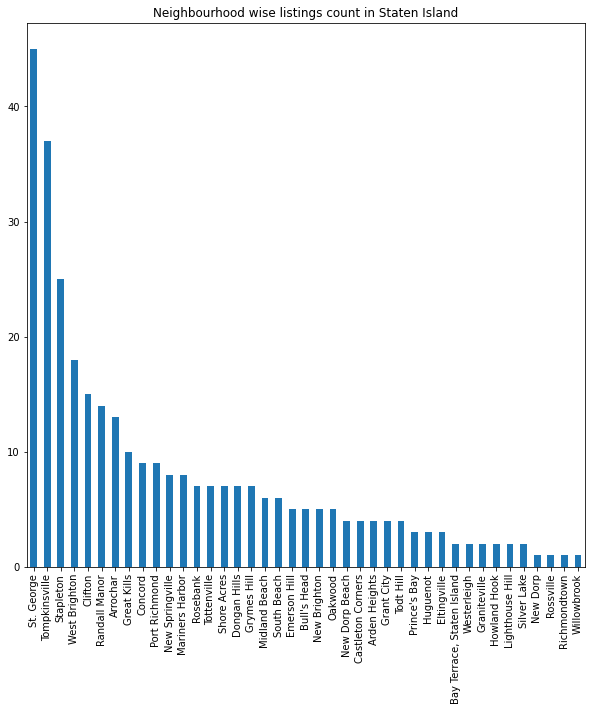

In [62]:
airbnb_stIsland = airbnb_df[(airbnb_df['neighbourhood_group'] == 'Staten Island')]
airbnb_stIsland['neighbourhood'].value_counts().plot(kind="bar")
plt.title('Neighbourhood wise listings count in Staten Island')
plt.show()

**Lets see room type listings for each neighbourhood group.**


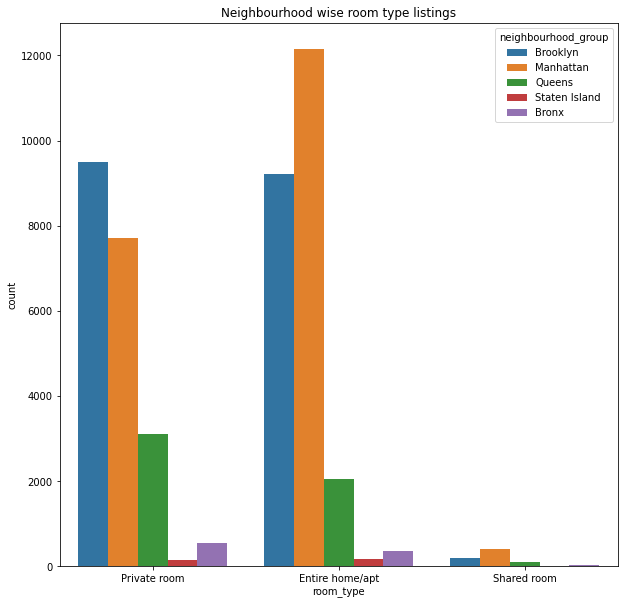

In [63]:
sb.countplot(x="room_type", hue="neighbourhood_group", data=airbnb_df)
plt.title('Neighbourhood wise room type listings')
plt.show()

****

**Its all about money! Lets see how pricing varies across different neighbourhood groups.**

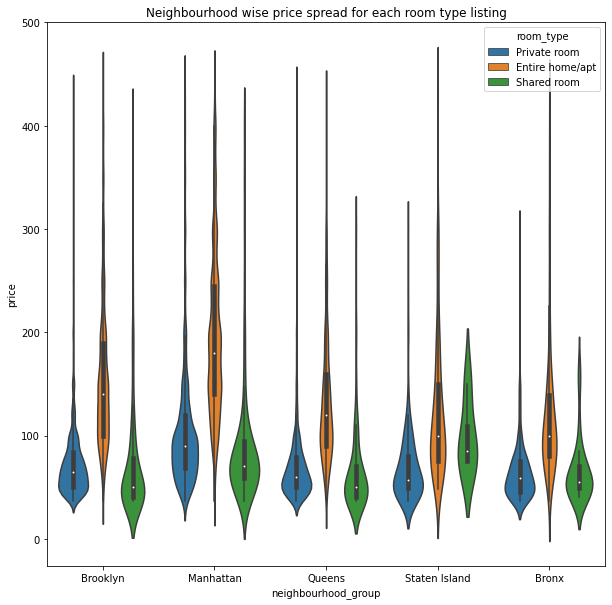

In [64]:
sb.violinplot(x="neighbourhood_group", y="price", hue="room_type", data=airbnb_df)
plt.title('Neighbourhood wise price spread for each room type listing')
plt.show()

**Lets see how pricing varies based on location in New York.**

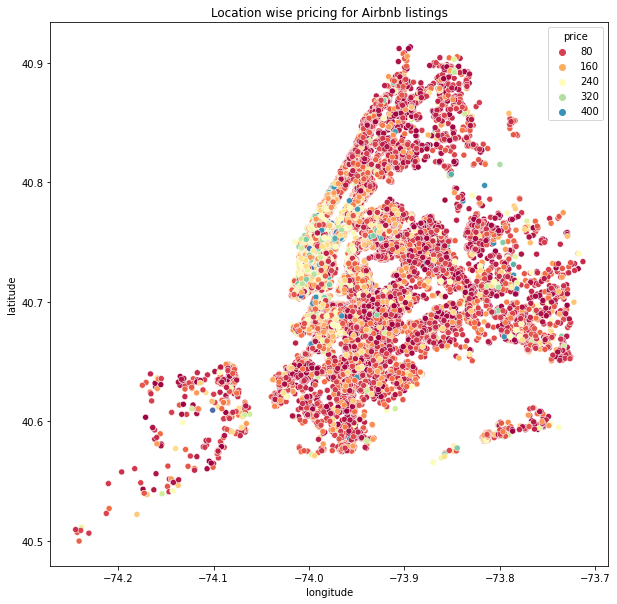

In [65]:
sb.scatterplot(x = airbnb_df.longitude, y = airbnb_df.latitude, hue = airbnb_df.price, palette="Spectral")
plt.title('Location wise pricing for Airbnb listings')
plt.show()

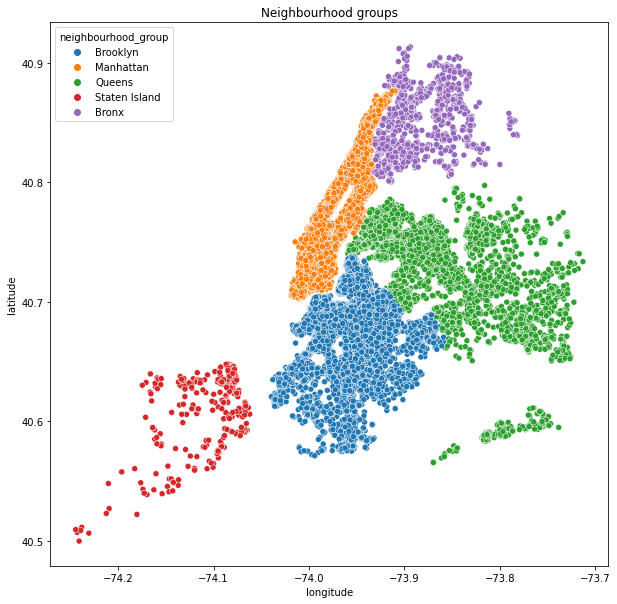

In [66]:
sb.scatterplot(x = airbnb_df.longitude, y = airbnb_df.latitude, hue = airbnb_df.neighbourhood_group)
plt.title('Neighbourhood groups')
plt.show()

**Lets plot busiest/most sought after Airbnb listings in New York.**

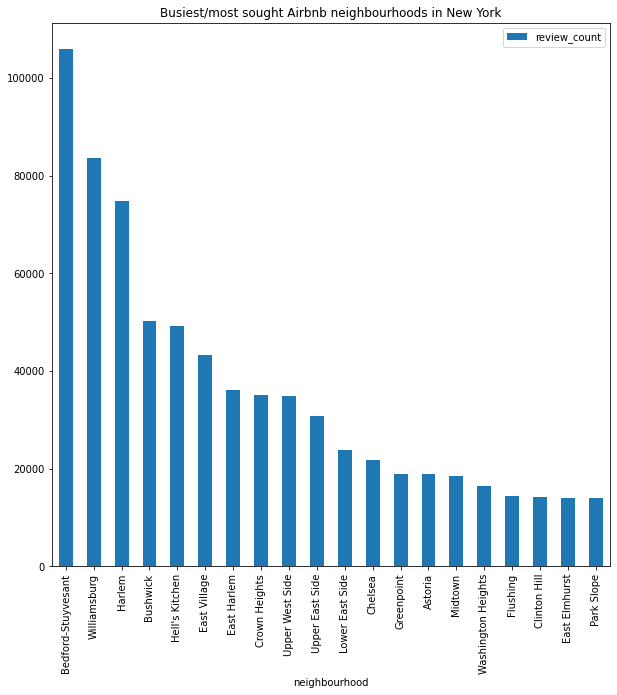

In [68]:
review_count_per_neighbourhood = airbnb_df.groupby('neighbourhood').number_of_reviews.sum().reset_index(name='review_count')
review_count_per_neighbourhood = review_count_per_neighbourhood.sort_values(by=['review_count'], ascending=False)
review_count_per_neighbourhood.head(20).plot(x='neighbourhood', y='review_count', kind='bar')
plt.title('Busiest/most sought Airbnb neighbourhoods in New York')
plt.show()

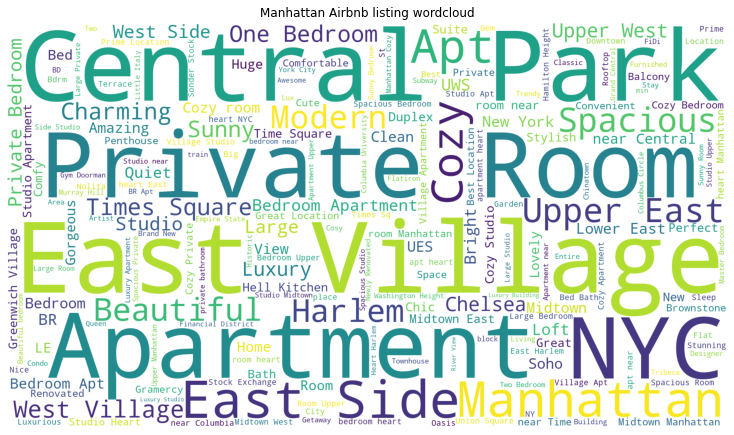

In [69]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width=1920, height=1080,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(airbnb_manhattan.name))

plt.title("Manhattan Airbnb listing wordcloud")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

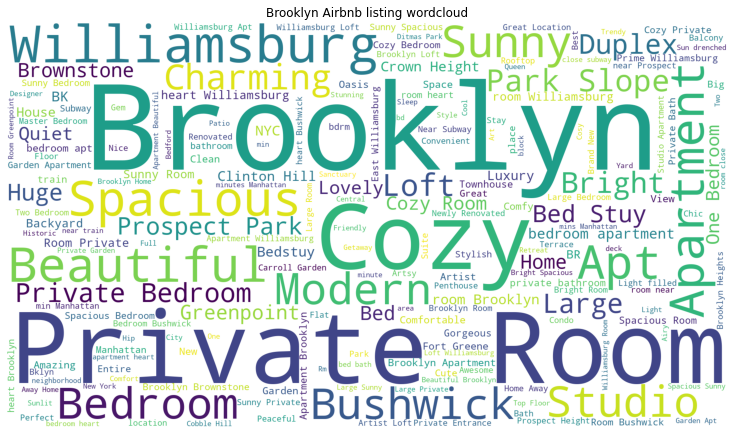

In [70]:
wordcloud = WordCloud(width=1920, height=1080,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(airbnb_brooklyn.name))

plt.title("Brooklyn Airbnb listing wordcloud")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

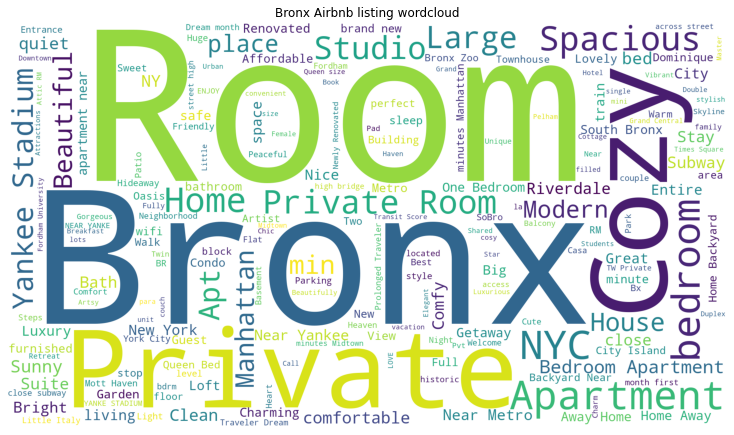

In [71]:
wordcloud = WordCloud(width=1920, height=1080,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(airbnb_bronx.name))

plt.title("Bronx Airbnb listing wordcloud")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

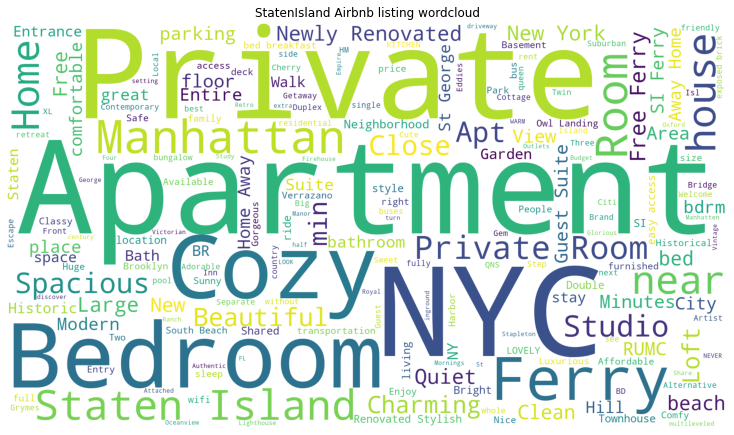

In [72]:
wordcloud = WordCloud(width=1920, height=1080,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(airbnb_stIsland.name))

plt.title("StatenIsland Airbnb listing wordcloud")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## **Model Training and Price Prediction**

In [73]:
airbnb_df.shape

(45736, 11)

In [74]:
airbnb_df.dtypes

name                    object
neighbourhood_group     object
neighbourhood           object
latitude               float64
longitude              float64
room_type               object
price                    int64
minimum_nights           int64
number_of_reviews        int64
reviews_per_month      float64
availability_365         int64
dtype: object

In [75]:
# x is our feature dataset comprising of columns neighbourhood_group, neighbourhood, latitude, longitude, room_type, minimum_nights, number_of_reviews, reviews_per_month, availability_365
x = airbnb_df.drop(['name', 'price'], axis=1)
# Encode categorical variables
x['neighbourhood_group']= x['neighbourhood_group'].factorize()[0]
x['neighbourhood']= x['neighbourhood'].factorize()[0]
x['room_type']= x['room_type'].factorize()[0]
x.describe()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365
count,45736.000000,45736.000000,45736.000000,45736.000000,45736.000000,45736.000000,45736.000000,45736.000000,45736.000000
mean,0.777899,29.203516,40.729252,-73.952256,0.556826,6.884861,23.901106,1.105518,110.410858
std,0.833851,33.748220,0.054270,0.045678,0.528582,19.917638,45.238707,1.606477,130.496946
min,0.000000,0.000000,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,40.690290,-73.982830,0.000000,1.000000,1.000000,0.050000,0.000000
50%,1.000000,19.000000,40.723080,-73.955630,1.000000,2.000000,5.000000,0.380000,42.000000
75%,1.000000,35.000000,40.763540,-73.936960,1.000000,5.000000,24.000000,1.620000,219.000000
max,4.000000,218.000000,40.913060,-73.712990,2.000000,1250.000000,629.000000,58.500000,365.000000


In [76]:
y = airbnb_df['price']
y.describe()

count    45736.000000
mean       130.722691
std         79.324323
min         37.000000
25%         70.000000
50%        105.000000
75%        170.000000
max        449.000000
Name: price, dtype: float64

In [77]:
# reference : https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=7)

regression = LinearRegression()

# Train the model using the training sets
regression.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regression.predict(x_test)

print('Coefficients: \n', regression.coef_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))




Coefficients: 
 [ 5.51154280e+00 -1.56347401e-01  6.37224894e+01 -4.01620174e+02
  6.96681759e+01 -1.62845673e-01 -1.06335627e-01  1.69306212e-01
  7.84714735e-02]
Mean squared error: 4218.07
Coefficient of determination: 0.31
